In [2]:
from wasserstein.basic_wasserstein import compute_sliced_wass_barycenter
from utils.image_treatment import preprocess_image, image_to_distribution
import matplotlib.pyplot as plt

In [12]:
image1 = preprocess_image('data/elephant.jpg', end = 'L')
image2 = preprocess_image('data/cercle.png', end = 'L')
x1 = image_to_distribution(image1)
x2 = image_to_distribution(image2)

In [26]:
def projection(X0, Y):
    """
    X0 : image a projeter 
    Y : ce sur quoi on veut projeter 
    """
    Y_distrib = [Y]
    proj = compute_sliced_wass_barycenter(Y_distrib, rho = None, lr = 1e3, k = 200, d = 2, nb_iter_max = 50, xbinit = X0)
    return(proj)

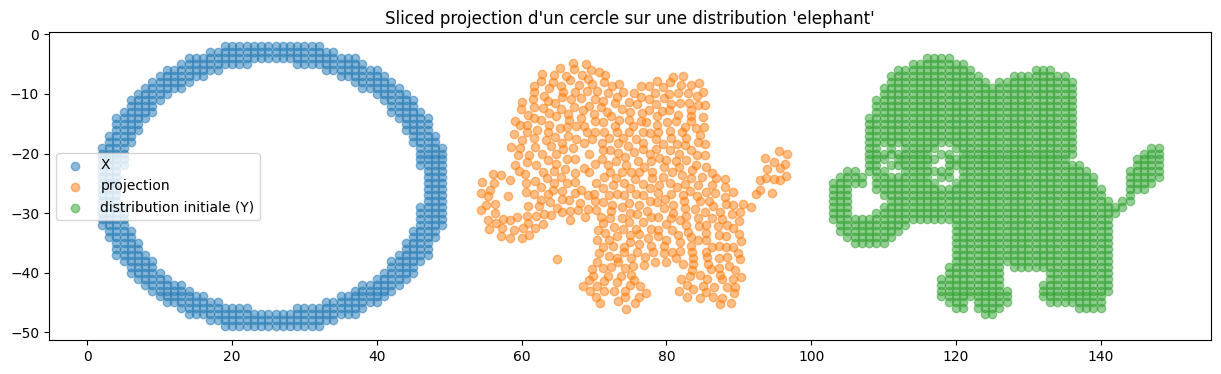

In [40]:
xprojection = projection(x2, x1)

plt.figure(6, (15, 4))
plt.scatter(x2[:, 0], x2[:, 1], alpha=0.5, label = 'X')
plt.scatter(xprojection[:, 0]+50, xprojection[:, 1], alpha=0.5, label = 'projection')
plt.scatter(x1[:, 0]+100, x1[:, 1], alpha=0.5, label = "distribution initiale (Y)")
plt.title("Sliced projection d'un cercle sur une distribution \'elephant\'")
plt.legend()

# Plot GIF

In [78]:
import torch 
import numpy as np 
import ot 

import matplotlib.pyplot as plt
import imageio

def compute_sliced_wass_barycenter(distributions, rho=None, lr=1e3, k=200, nb_iter_max=50, xbinit=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    x_torch = [torch.tensor(x).to(device=device) for x in distributions]

    if rho is None: 
        n = len(distributions)
        rho = n * [1 / n]
    
    if xbinit is None:
        xbinit = np.random.normal(0., 1., distributions[0].shape)
    xbary_torch = torch.tensor(xbinit).to(device=device).requires_grad_(True)

    x_all = np.zeros((nb_iter_max, xbary_torch.shape[0], xbary_torch.shape[1]))
    loss_iter = []

    # generator for random projections
    gen = torch.Generator(device=device)
    gen.manual_seed(42)

    for i in range(nb_iter_max):
        loss = 0
        for j, x in enumerate(x_torch):
            loss += rho[j] * ot.sliced_wasserstein_distance(xbary_torch, x, n_projections=50, seed=gen)
        loss_iter.append(loss.clone().detach().cpu().numpy())
        loss.backward()

        # Perform gradient descent
        with torch.no_grad():
            grad = xbary_torch.grad
            xbary_torch -= grad * lr  # / (1 + i / 5e1)  # step
            xbary_torch.grad.zero_()
            x_all[i, :, :] = xbary_torch.clone().detach().cpu().numpy()
        lr *= 0.95
    xb = xbary_torch.clone().detach().cpu().numpy()

    return (xb, x_all)


def create_gif(x_all, y_points, filename="projection.gif"):
    """
    Crée un GIF montrant l'évolution de X vers Y.
    
    Parameters:
        x_all : ndarray
            Tableau contenant l'évolution de X à chaque itération.
        y_points : ndarray
            Points de Y pour référence.
        filename : str
            Nom du fichier GIF généré.
    """
    images = []
    for i, x in enumerate(x_all):
        plt.figure(figsize=(6, 6))
        
        # Modifier la couleur de fond
        ax = plt.gca()
        ax.set_facecolor('lightgray')
        
        # Tracer les points
        plt.scatter(x[:, 0], x[:, 1], c='blue', label='Projected X', alpha=0.6)
        plt.scatter(y_points[:, 0], y_points[:, 1], c='red', label='Target Y', alpha=0.2)
        
        # Ajouter une légende
        plt.legend()

        # Ajouter le numéro d'itération en bas à gauche
        plt.text(2, -48, f"Iteration {i + 1}", fontsize=12, color='black',
                 ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7))
        
        
        # Ajuster les limites
        plt.xlim(0, 50)
        plt.ylim(-50, 0)
        
        # Supprimer les axes et la grille
        plt.axis('off')
        
        # Sauvegarder chaque frame
        plt.savefig("frame.png", bbox_inches='tight', pad_inches=0)
        images.append(imageio.imread("frame.png"))
        plt.close()
    
    # Combine images into a GIF
    imageio.mimsave(filename, images, fps=5, loop=5)


In [79]:
image1 = preprocess_image('data/elephant.jpg', end = 'L')
image2 = preprocess_image('data/cercle.png', end = 'L')
x1 = image_to_distribution(image1)
x2 = image_to_distribution(image2)

In [82]:
# Calcul de la projection
proj, x_all = compute_sliced_wass_barycenter([x1], xbinit=x2, nb_iter_max=50)

In [83]:
# Création du GIF
create_gif(x_all, x1, filename="outputs/projection.gif")

/var/folders/ls/kz9r5k393xg8d3p1krqjx50m0000gn/T/ipykernel_33699/3466324526.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("frame.png"))
